In [21]:
import pyaudio
import wave
import keyboard
import time
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy import signal
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchaudio


RATE = 44100*2

In [261]:
class SiameseDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.file_names = os.listdir(data_dir)

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self,index):
        # Get name of file
        file = self.file_names[index]
        file_path = os.path.join(self.data_dir, file)

        # load the audio file
        waveform, sample_rate= torchaudio.load(file_path)
        
        # print(sample_rate)

        n_fft = 1024  # Size of the FFT window
        hop_length = 130  # Hop length for frame spacing
        n_mels = 64  # Number of Mel filterbanks

        # Create the MelSpectrogram transform
        mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels
        )
        mel_spectrogram = mel_transform(waveform)

        mel_spectrogram = mel_spectrogram.numpy()
        mel_spectrogram = np.squeeze(mel_spectrogram)
        mel_spectrogram = np.log10(mel_spectrogram)

        print(file)

        components = file.split('_')
        label = components[-2]
        print(f'label is {label}')

        
        return mel_spectrogram, label


In [310]:
i = 0

2023-06-27_12-45-20_space_(1).wav
label is space


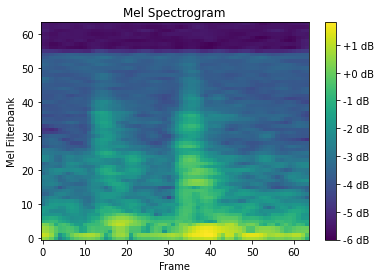

[[ 0.54865205  0.4192054  -0.02846015 ...  0.3279193  -0.04256838
  -0.98738146]
 [ 1.1750461   1.0455995   0.5979339  ...  0.9543134   0.58382565
  -0.36098742]
 [ 0.732935    0.62923956  0.33007643 ...  0.0275074   0.09536604
   0.12585488]
 ...
 [-5.342594   -5.396886   -5.536019   ... -5.505594   -5.3900356
  -5.34445   ]
 [-5.434324   -5.475258   -5.5342326  ... -5.686657   -5.67956
  -5.672159  ]
 [-5.481217   -5.5090857  -5.5554237  ... -5.5246935  -5.498018
  -5.4795613 ]]


In [333]:
# Create an instance of the dataset
dataset = SiameseDataset("output")
mel_spectrogram = dataset[i]
i += 1


# Visualize the Mel spectrogram
plt.imshow(mel_spectrogram, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Frame')
plt.ylabel('Mel Filterbank')
plt.title('Mel Spectrogram')
plt.show()

print(mel_spectrogram)